# Question


Using the Auto MPG dataset to predict the fuel efficiency.

Data hosted on http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/.
The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.

Attribute Information:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# Read Dataset

In [3]:
data_set = pd.read_csv('auto-mpg.data', 
                       names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 
                                'Acceleration', 'Model Year', 'Origin'],
                       na_values = '?', comment = '\t', skipinitialspace = True, sep = ' ')
complete_dataset = data_set.copy()

In [4]:
print(complete_dataset.shape)
complete_dataset.tail(5)

(398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


Text(0.5, 1.0, 'Origin Value Count')

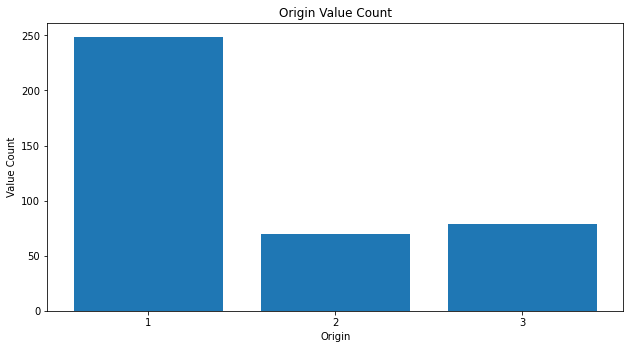

In [6]:
origin_analysis = complete_dataset.groupby('Origin')['MPG'].count()

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(origin_analysis.index, origin_analysis.values)
ax.set_xlabel('Origin')
ax.set_ylabel('Value Count')
ax.set_xticks(origin_analysis.index)
ax.set_title('Origin Value Count')

# Checking and Imputing the null values in the dataset

In [7]:
complete_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
complete_dataset[complete_dataset['Horsepower'].isna()]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
126,21.0,6,200.0,NaN,2875.0,17.0,74,1
330,40.9,4,85.0,NaN,1835.0,17.3,80,2
336,23.6,4,140.0,NaN,2905.0,14.3,80,1
354,34.5,4,100.0,NaN,2320.0,15.8,81,2
374,23.0,4,151.0,NaN,3035.0,20.5,82,1


# Check Correlation

Text(0.5, 1.0, 'Heatmap of Correlation')

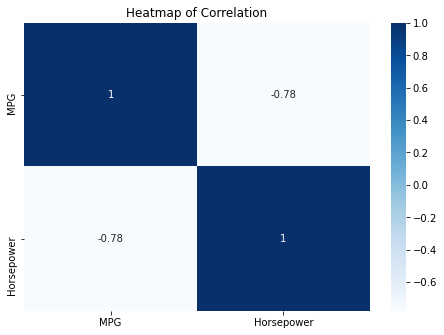

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.heatmap(complete_dataset[['MPG','Horsepower']].corr(), cmap='Blues', annot=True)
ax.set_title('Heatmap of Correlation')

Since the correlation value is high, we'll drop the null values from our dataset instead of imputing.

In [10]:
complete_dataset = complete_dataset.dropna()

# Checking categorical columns

In [11]:
complete_dataset['Origin'].value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

Instead of using categorical values, we'll use one hot encoding, as we're later going to use a linear regression model which 
unlike decision trees, does not work great with categorical values.

In [12]:
origin_col = complete_dataset.pop('Origin')
complete_dataset['1'] = (origin_col==1)*1
complete_dataset['2'] = (origin_col==2)*1
complete_dataset['3'] = (origin_col==3)*1

In [13]:
complete_dataset.tail(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,1,2,3
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


# Split into train and test dataset 

In [14]:
train = complete_dataset.sample(frac=0.8, random_state=0)
test = complete_dataset.drop(train.index)

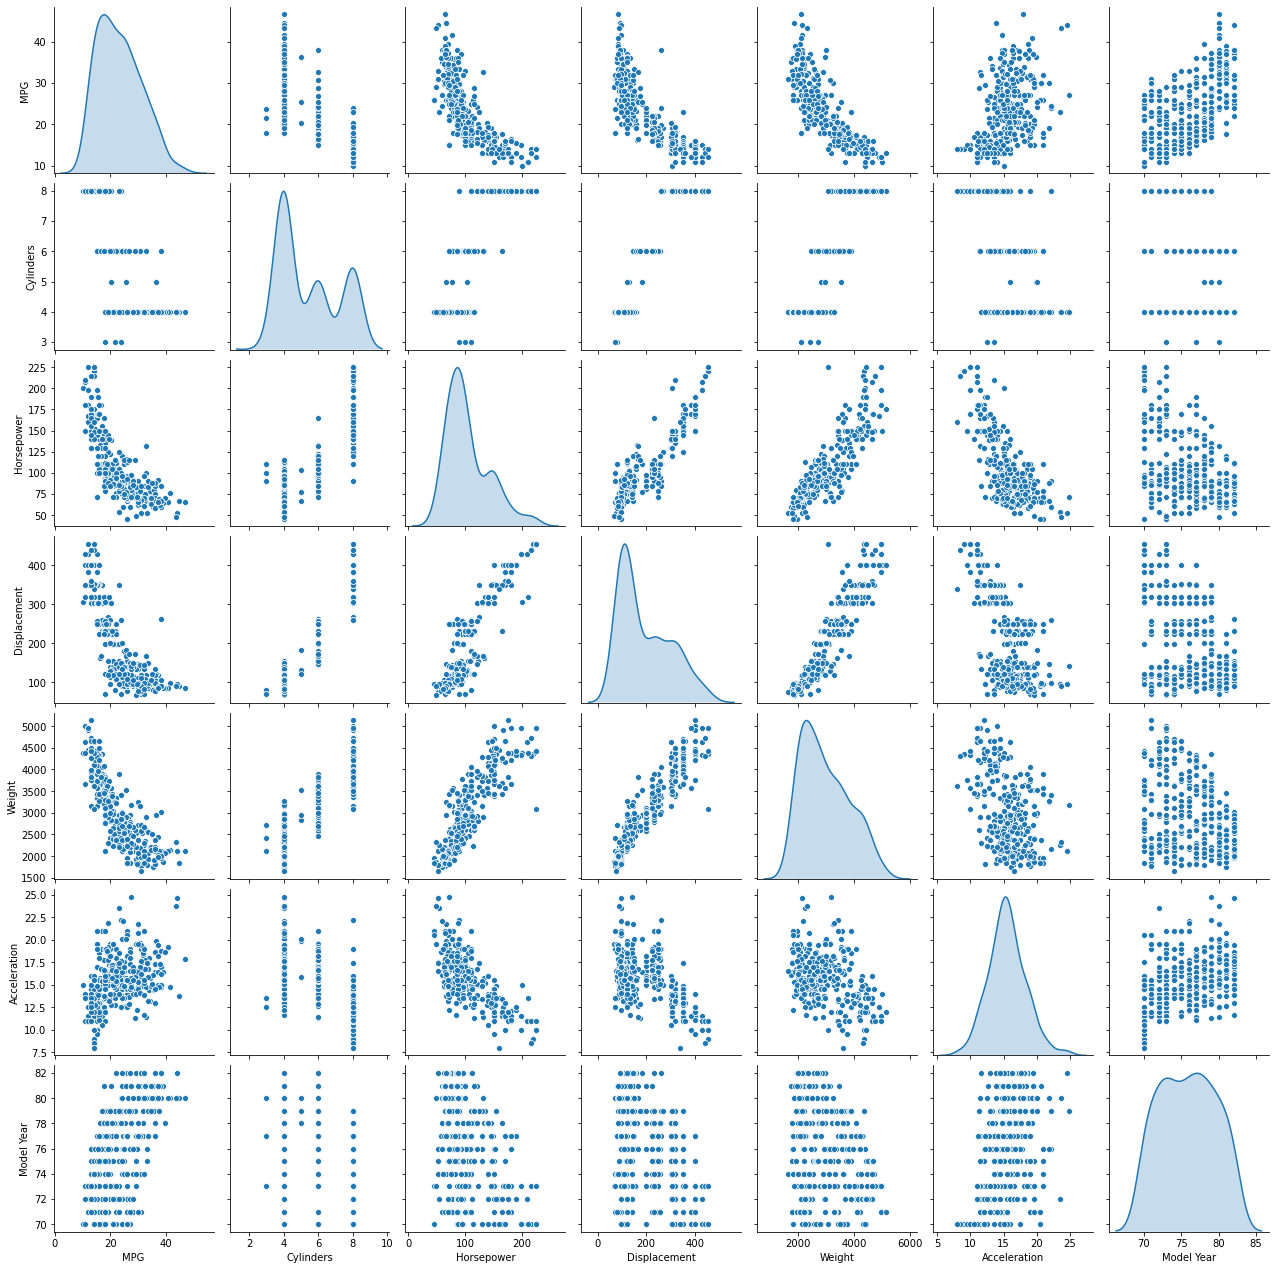

In [15]:
sns.pairplot(train[['MPG', 'Cylinders', 'Horsepower', 'Displacement', 'Weight', 'Acceleration', 'Model Year']], diag_kind='kde')

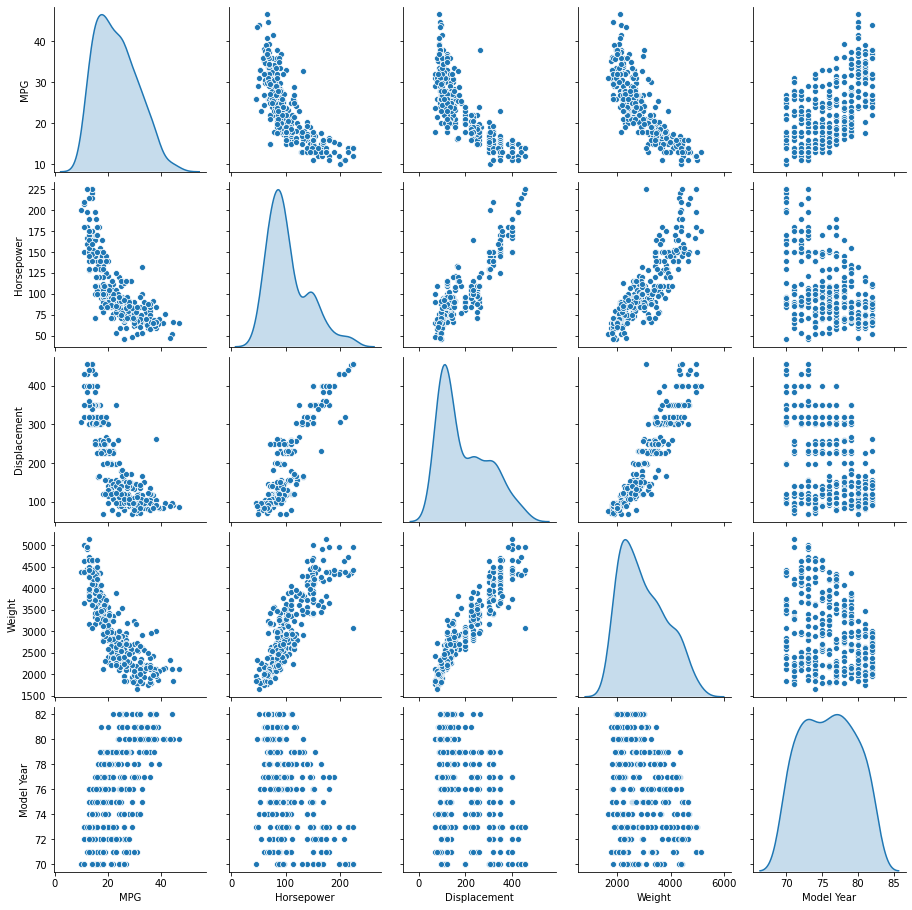

In [16]:
sns.pairplot(train[['MPG', 'Horsepower', 'Displacement', 'Weight', 'Model Year']], diag_kind='kde')

From the above plots, we can see the correlation between MPG and the other attributes. 
We can also safely assume that MPG is a function of all the other attributes.

In [17]:
print(train.shape, test.shape)
train.describe()

(314, 10) (78, 10)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,1,2,3
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.624204,0.178344,0.197452
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.485101,0.383413,0.398712
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [18]:
#Features
train_features = train.copy()
test_features = test.copy()
#Labels
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

Since all the attributes are in different ranges, which can become a problem for the model, as higher values will have more influence in prediction even if their importance as a predictor is minimal.
Therefore we're going to Normalize the data, to 1NF, i.e mean = 0 and standard deviation = 1

In [19]:
train.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
1,0.624204,0.485101
2,0.178344,0.383413
3,0.197452,0.398712


In [20]:
# Importing modules for tensorflow and Keras API
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [21]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

#To check for 1 example
first = np.array(train_features[:1])
with np.printoptions(precision=3, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]

Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


# Firstly we'll build a Sequential (Linear Regression) Model with Keras

Predicting 1 output for each example, on the line y = mx + c with m as the matrix of features

In [22]:
lr_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

lr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


To check if everything's working, we'll run the untrained model on the first 10 examples of the train dataset. 

In [23]:
lr_model.predict(train_features[:10])

array([[-0.58090276],
       [ 0.05374232],
       [ 0.12797643],
       [ 0.7785628 ],
       [-1.3696167 ],
       [-0.25433487],
       [-1.691577  ],
       [ 1.6584558 ],
       [-0.7913882 ],
       [-2.787982  ]], dtype=float32)

Finally, compile and train the model, with a learning rate of 0.1, calculating the loss as mean absolute percent error

In [24]:
lr_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.1),
    loss=keras.losses.MeanAbsolutePercentageError())

In [25]:
model_train = lr_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 4s 419ms/step - loss: 97.3432 - val_loss: 89.6463
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 86.1122 - val_loss: 86.3541
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 83.5895 - val_loss: 84.8750
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 79.1569 - val_loss: 80.4445
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 76.3501 - val_loss: 76.2065
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 69.5781 - val_loss: 73.0172
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 69.3913 - val_loss: 70.2914
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 63.3058 - val_loss: 68.0514
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 64.0231 - val_loss: 63.8496
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 58.4373 - val_loss: 61.0657
Epoch 1

8/8 [==============================] - 0s 8ms/step - loss: 10.5363 - val_loss: 10.7240
Epoch 84/100
8/8 [==============================] - 0s 8ms/step - loss: 10.2895 - val_loss: 10.7386
Epoch 85/100
8/8 [==============================] - 0s 8ms/step - loss: 10.7746 - val_loss: 10.7806
Epoch 86/100
8/8 [==============================] - 0s 9ms/step - loss: 9.9737 - val_loss: 10.8631
Epoch 87/100
8/8 [==============================] - 0s 8ms/step - loss: 10.1585 - val_loss: 10.9049
Epoch 88/100
8/8 [==============================] - 0s 8ms/step - loss: 11.4723 - val_loss: 10.8723
Epoch 89/100
8/8 [==============================] - 0s 7ms/step - loss: 10.2099 - val_loss: 10.8659
Epoch 90/100
8/8 [==============================] - 0s 7ms/step - loss: 9.3986 - val_loss: 10.8505
Epoch 91/100
8/8 [==============================] - 0s 9ms/step - loss: 9.6589 - val_loss: 10.9161
Epoch 92/100
8/8 [==============================] - 0s 9ms/step - loss: 10.1462 - val_loss: 10.8253
Epoch 93/100
8/8

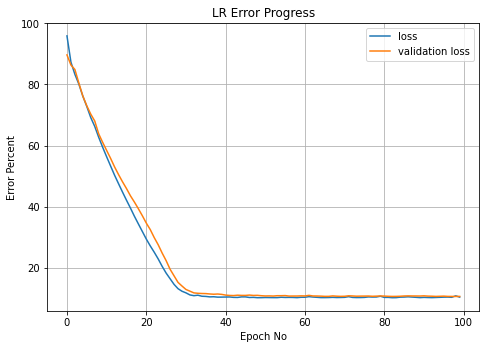

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(model_train.history['loss'], label='loss')
ax.plot(model_train.history['val_loss'], label='validation loss')
ax.set_xlabel('Epoch No')
ax.set_ylabel('Error Percent')
ax.set_title('LR Error Progress')
ax.legend()
ax.grid(True)

Final Loss = 10.76%, which gives us a 90% accuracy model roughly.
From the graphs we can see, that the loss has decreased till the 30th epoch and finally set at around 10% since.

In [27]:
results = {} #To Store results
results['linear_regression_model (MAP-E%)'] = lr_model.evaluate(
    test_features, test_labels, verbose=0)

# Getting the predictions and curve for LR model

In [28]:
lr_predictions = lr_model.predict(test_features).flatten()

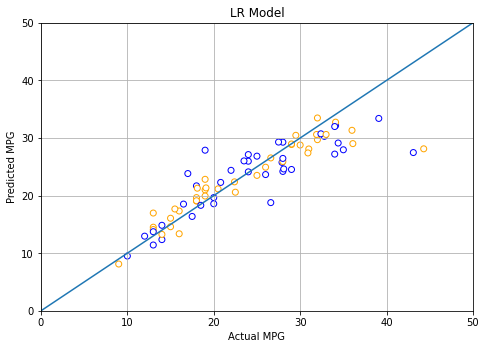

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(test_labels, lr_predictions, edgecolors=['orange', 'blue'], color='white')
lims = [0, 50]
ax.set_xlim(lims)
ax.set_ylim(lims)
_ = ax.plot(lims, lims)
ax.set_xlabel('Actual MPG')
ax.set_ylabel('Predicted MPG')
ax.set_title('LR Model')
ax.grid(True)

We can see that the model predicts data pretty well, with almost 90% accuracy

# Random Forest implementation

Since I'm working on a Windows system, we'll be using sklearn.

In [30]:
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Here we're implementing a random forest regressor with a random state as 1

In [31]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_features, train_labels)
rf_predictions = forest_model.predict(test_features)

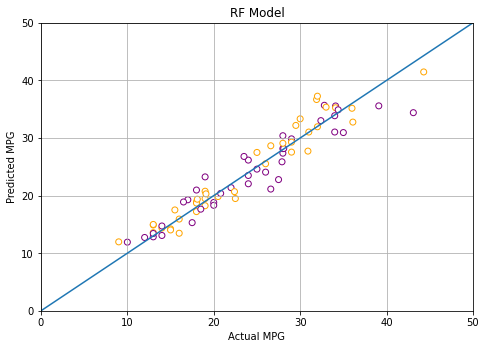

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(test_labels, rf_predictions, edgecolors=['orange', 'purple'], color='white')
lims = [0, 50]
ax.set_xlim(lims)
ax.set_ylim(lims)
_ = ax.plot(lims, lims)
ax.set_xlabel('Actual MPG')
ax.set_ylabel('Predicted MPG')
ax.set_title('RF Model')
ax.grid(True)

From the above plot, we can see, that the Random Forest regressor gives a really good output with an accuracy of 93%(approx.). It's significantly better than the Linear Regressor model.

In [33]:
results['rf_model (MAP-E%)'] = mean_absolute_percentage_error(test_labels, rf_predictions)

# Decision Tree implementation

Since I'm working on a Windows system, we'll be using sklearn.

In [34]:
from sklearn import tree

In [35]:
dt_model = tree.DecisionTreeRegressor()
dt_model_fitted = dt_model.fit(train_features, train_labels)

Get Predictions from decision tree model

In [36]:
dt_predictions = dt_model_fitted.predict(test_features)

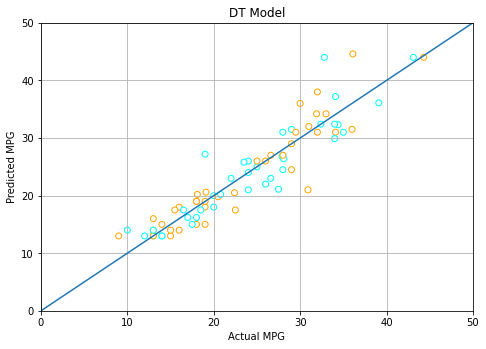

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(test_labels, dt_predictions, edgecolors=['orange', 'cyan'], color='white')
lims = [0, 50]
ax.set_xlim(lims)
ax.set_ylim(lims)
_ = ax.plot(lims, lims)
ax.set_xlabel('Actual MPG')
ax.set_ylabel('Predicted MPG')
ax.set_title('DT Model')
ax.grid(True)

From the above plot, we can see, that the Decision Tree regressor gives a better output than the Linear Regressor with an accuracy of 90%(approx.). However, bthe Random Forest approach prove to be significantly better.

In [38]:
results['dt_model (MAP-E%)'] = mean_absolute_percentage_error(test_labels, dt_predictions)

# Deep Neural Net implementation

In [39]:
model_dnn = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [40]:
model_dnn.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss=keras.losses.MeanAbsolutePercentageError())

model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


Here we're using a learning rate of 0.001 with two hidden non linear layers with 'relu' non-linearity and 1 output layer

In [41]:
model_dnn_mae = model_dnn.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 37ms/step - loss: 100.3620 - val_loss: 96.8955
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 96.4511 - val_loss: 92.4004
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 92.1067 - val_loss: 87.3745
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 87.4586 - val_loss: 81.4984
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 81.9302 - val_loss: 74.0457
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 73.0726 - val_loss: 65.7395
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 66.2482 - val_loss: 61.3012
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 60.0047 - val_loss: 58.0030
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 53.9364 - val_loss: 51.5315
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 47.5416 - val_loss: 42.9186
Ep

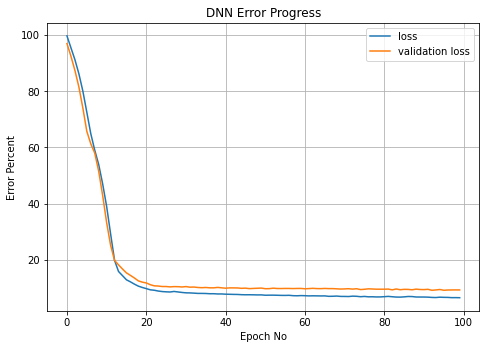

In [42]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(model_dnn_mae.history['loss'], label='loss')
ax.plot(model_dnn_mae.history['val_loss'], label='validation loss')
ax.set_xlabel('Epoch No')
ax.set_ylabel('Error Percent')
ax.set_title('DNN Error Progress')
ax.legend()
ax.grid(True)

As for the dnn model we can see the steep fall in loss till the 20th epoch, however it continues to decrease little by little till we reach the 100th epoch. With a final loss = 7.55%

In [43]:
results['dnn_model (MAP-E%)'] = model_dnn.evaluate(
    test_features, test_labels, verbose=0)

The accuracy percentage significantly improved to 93% approx.

# Getting the predictions and curve for DNN model

In [44]:
dnn_predictions = model_dnn.predict(test_features).flatten()

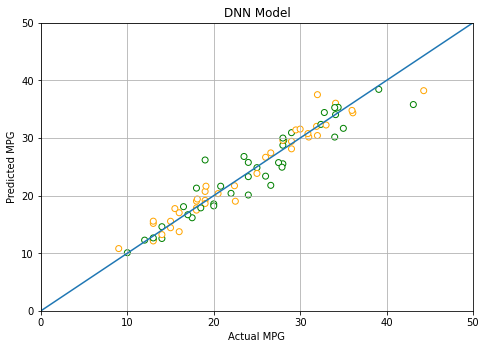

In [45]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(test_labels, dnn_predictions, edgecolors=['orange', 'green'], color='white')
lims = [0, 50]
ax.set_xlim(lims)
ax.set_ylim(lims)
_ = ax.plot(lims, lims)
ax.set_xlabel('Actual MPG')
ax.set_ylabel('Predicted MPG')
ax.set_title('DNN Model')
ax.grid(True)

# Comparing all the Approaches

In [46]:
result_df = pd.DataFrame(list(zip(dnn_predictions, test_labels-dnn_predictions, lr_predictions, test_labels-lr_predictions, 
                      rf_predictions,  test_labels-rf_predictions, dt_predictions,  test_labels-dt_predictions, test_labels)),
             columns=['DNN Predictions', 'DNN Offset', 'LR Predictions', 'LR Offset', 'RF Predictions', 'RF Offset',
                      'DT Predictions', 'DT Offset', 'Actual Value'])
result_df

,DNN Predictions,DNN Offset,LR Predictions,LR Offset,RF Predictions,RF Offset,DT Predictions,DT Offset,Actual Value
0,15.545376,-0.545376,14.596184,0.403816,14.220,0.780,13.0,2.0,15.0
1,10.086155,-0.086155,9.510118,0.489882,11.920,-1.920,14.0,-4.0,10.0
2,10.804134,-1.804134,8.120345,0.879655,11.970,-2.970,13.0,-4.0,9.0
3,24.852959,0.147041,26.848896,-1.848896,24.598,0.402,25.0,0.0,25.0
4,20.723904,-1.723904,20.981030,-1.981030,19.486,-0.486,18.0,1.0,19.0
...,...,...,...,...,...,...,...,...,...
73,30.164808,3.835192,27.205006,6.794994,31.038,2.962,29.9,4.1,34.0
74,34.790234,1.209766,31.335468,4.664532,35.163,0.837,31.5,4.5,36.0
75,35.278118,-1.278118,31.989376,2.010624,33.866,0.134,32.4,1.6,34.0
76,37.526340,-5.526340,33.476589,-1.476589,37.257,-5.257,38.0,-6.0,32.0


In [47]:
model_scores = pd.DataFrame(results.values(), index=results.keys(), columns=['Accuracy'])
model_scores

,Accuracy
linear_regression_model (MAP-E%),10.659617
rf_model (MAP-E%),7.822648
dt_model (MAP-E%),10.234211
dnn_model (MAP-E%),7.173465


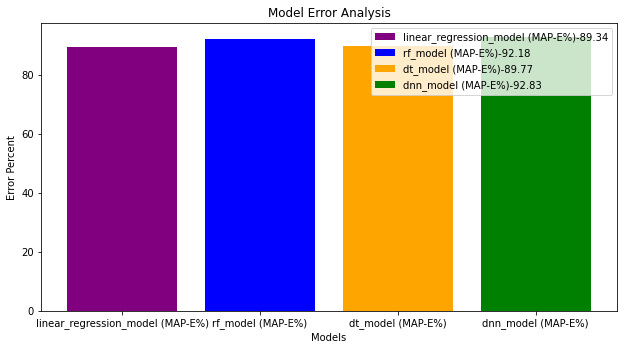

In [48]:
prediction_results = list(map(lambda x: round(100-x, 2), model_scores['Accuracy']))
labels = list(results.keys())
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
colors=['grey', 'purple', 'blue', 'yellow', 'green']
ax.bar(labels[0], prediction_results[0], color='purple', label=labels[0]+'-'+str(prediction_results[0]))
ax.bar(labels[1], prediction_results[1], color='blue', label=labels[1]+'-'+str(prediction_results[1]))
ax.bar(labels[2], prediction_results[2], color='orange', label=labels[2]+'-'+str(prediction_results[2]))
ax.bar(labels[3], prediction_results[3], color='green', label=labels[3]+'-'+str(prediction_results[3]))
ax.set_xlabel('Models')
ax.set_ylabel('Error Percent')
ax.set_xticklabels(labels)
ax.set_title('Model Error Analysis')
ax.legend()

In [49]:
model_dnn.save('dnn_model')
lr_model.save('lr_model')
import pickle
pickle.dump(dt_model,open("dt_model.pkl",'wb'))
pickle.dump(forest_model,open("forest_model.pkl",'wb'))

INFO:tensorflow:Assets written to: dnn_model\assets
INFO:tensorflow:Assets written to: lr_model\assets
